In [10]:
from tensorflow.keras import backend as K

from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input, Dense, Lambda,Conv1D,Conv2DTranspose, LeakyReLU,Activation,Flatten,Reshape
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import emcee
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
JV_raw = np.loadtxt("/mnt/c/Users/pssrg/Downloads/GaAs_sim_nJV.txt")
par = np.loadtxt("/mnt/c/Users/pssrg/Downloads/GaAs_sim_label.txt")

In [12]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides ):
    
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1),padding='SAME')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#Covert labels from log10 form to log
        
def log10_ln(x):
    return np.log(np.power(10,x))

par = log10_ln(par)


#Data normalization for the whole JV dataset

def min_max(x):
    min = np.min(x)
    max = np.max(x)
    return (x-min)/(max-min),max,min

#Normalize raw JV data

JV_norm,JV_max,JV_min = min_max(JV_raw)

#Normalize JV descriptors column-wise
scaler = MinMaxScaler()

par_n = scaler.fit_transform(par)   

#create training and testing datset

X_train, X_test, y_train, y_test = train_test_split(JV_norm,par_n, test_size=0.2)

#add in Gaussian noise to train the denoising Autoencoder

X_train_nos = X_train+0.002 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 

X_test_nos = X_test+0.002 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

def build_regression_model(label_dim=5, max_filter=256, map_size = 25, kernel=[7, 5, 3], strides=[5, 2, 2]):
    z_in = tf.keras.Input(shape=(label_dim,))  # input: material descriptors (5,)
    
    # Dense expansion
    z = layers.Dense(100, activation='relu')(z_in)
    z = layers.Dense(max_filter * map_size, activation='relu')(z)
    z = layers.Reshape((map_size, 1, max_filter))(z)
    
    # Deconvolution blocks
    z = layers.Conv2DTranspose(max_filter // 2, (kernel[2], 1), strides=(strides[2], 1), padding='same')(z)
    z = layers.Activation('relu')(z)
    
    z = layers.Conv2DTranspose(max_filter // 4, (kernel[1], 1), strides=(strides[1], 1), padding='same')(z)
    z = layers.Activation('relu')(z)
    
    z = layers.Conv2DTranspose(1, (kernel[0], 1), strides=(strides[0], 1), padding='same')(z)
    z = layers.Activation('sigmoid')(z)

    # Remove singleton dimensions (squeeze)
    z = layers.Lambda(lambda x: tf.squeeze(x, axis=2))(z)  # remove width = 1
    z = layers.Lambda(lambda x: tf.squeeze(x, axis=2))(z)  # remove channel = 1

    model = tf.keras.Model(inputs=z_in, outputs=z)
    return model

In [14]:

reg_model = build_regression_model()
reg_model.compile(optimizer='adam', loss='mse')

reg_model.fit(par_n, JV_norm, batch_size=128, epochs=50, shuffle=True)


Epoch 1/50


I0000 00:00:1753627377.523228    8271 service.cc:152] XLA service 0x7f95e4013a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753627377.523392    8271 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-27 14:42:57.659699: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753627378.073112    8271 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-27 14:43:00.196396: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_197', 392 bytes spill stores, 392 bytes spill loads

2025-07-27 14:43:00.421727: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

 15/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0638 

I0000 00:00:1753627386.030374    8271 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


149/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229

2025-07-27 14:43:08.393539: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_197', 20 bytes spill stores, 20 bytes spill loads

2025-07-27 14:43:08.916715: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_473', 64 bytes spill stores, 64 bytes spill loads

2025-07-27 14:43:09.065157: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_473', 4 bytes spill stores, 4 bytes spill loads

2025-07-27 14:43:09.084833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_473', 56 bytes spill stores, 56 bytes spill loads



157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0220
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5126e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4232e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2647e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7112e-05
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2211e-05
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7022e-05
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3180e-05
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3098e-05
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8181e-05
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7407e-05
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4512e-05
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1189e-05
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8811e-05
Epoch 15/50
15

In [15]:
import tensorflow as tf


# Define initial trainable variables for 5 descriptors × 3 parameters = 15
theta = tf.Variable([0.0, 0.0, 0.5]*5 + 1e-6 * tf.random.normal([15], dtype=tf.float32))
print(theta)
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-2)
T_vals = np.array([530, 580, 630, 650, 680], dtype=np.float32)
x_vals = -1000.0 / T_vals
JV_exp = tf.convert_to_tensor(np.loadtxt('/mnt/c/Users/pssrg/Downloads/GaAs_exp_nJV.txt'), dtype=tf.float32)
# Objective function: Negative log-likelihood = squared error loss
def loss_fn():
    # Extract x and prepare descriptor input
    x = tf.convert_to_tensor(x_vals, dtype=tf.float32)
    inv_x = -1.0 / x
    log_input = tf.clip_by_value(inv_x, 1e-6, 1e6)

    a = theta[0::3]  # every 3rd starting at 0
    b = theta[1::3]
    c = theta[2::3]

    descriptors = []
    for i in range(5):
        lin = a[i] * tf.math.log(log_input) + b[i] * x + c[i]
        descriptors.append(lin)
    par_input = tf.stack(descriptors, axis=-1)
    par_input_scaled = 10 * par_input
    jv_pred = reg_model(par_input_scaled, training=False)
    sigma = tf.constant(1e-4, dtype=tf.float32)
    loss = tf.reduce_mean(tf.square((JV_exp - jv_pred) / sigma))
    return loss
Samples = []
for step in range(1000):
    Samples.append(tf.identity(theta))
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    grads = tape.gradient(loss_value, [theta])
    optimizer.apply_gradients(zip(grads, [theta]))

    if step % 50 == 0:
        print(f"Step {step}: Loss = {loss_value.numpy():.4f}")


<tf.Variable 'Variable:0' shape=(15,) dtype=float32, numpy=
array([ 7.7848404e-07, -8.4753587e-08,  4.9999911e-01,  1.3048276e-06,
        5.7538927e-07,  5.0000072e-01, -2.3749995e-07, -5.4490687e-07,
        5.0000221e-01, -1.2660000e-06, -1.5010236e-06,  4.9999985e-01,
        1.1134813e-06, -8.0168240e-07,  4.9999979e-01], dtype=float32)>
Step 0: Loss = 23396322.0000
Step 50: Loss = 361536.6250
Step 100: Loss = 28929.6738
Step 150: Loss = 13099.2324
Step 200: Loss = 38593.9258
Step 250: Loss = 66346.0703
Step 300: Loss = 5720.9102
Step 350: Loss = 4103.8018
Step 400: Loss = 3705.0007
Step 450: Loss = 3525.7173
Step 500: Loss = 4010.5967
Step 550: Loss = 4849.9902
Step 600: Loss = 3617.5669
Step 650: Loss = 3664.8640
Step 700: Loss = 4673.4546
Step 750: Loss = 4293.4922
Step 800: Loss = 5154.0742
Step 850: Loss = 3620.2627
Step 900: Loss = 9917.7539
Step 950: Loss = 3400.6892


In [16]:
optimized_params = theta.numpy()
print("Optimized coefficients:")
print(optimized_params)

Optimized coefficients:
[-0.33650827  0.08135965  0.0169958   0.00113177  0.11083838  0.23195486
  0.17187928  0.16080238  0.4122583   0.07889425  0.15173447  0.27975857
  0.24425586  0.13919017  0.43298712]


In [18]:
def check_plot(theta,x,sim):
    
    a1,b1,c1, a2,b2,c2, a3,b3,c3, a4,b4,c4, a5,b5,c5 = theta
    emitter_doping = a1*np.log(-1/x)+b1*x+c1
    back_doping = a2*np.log(-1/x)+b2*x+c2
    tau = (a3*np.log(-1/x)+b3*x+c3)
    fsrv = (a4*np.log(-1/x)+b4*x+c4)
    rsrv = (a5*np.log(-1/x)+b5*x+c5)

    
    
    par_input = 10*np.stack((emitter_doping,back_doping,tau,fsrv,rsrv),axis=-1)
    if sim == 0 :
        unnorm_par = scaler.inverse_transform(par_input)
        return par_input,unnorm_par
        
    sim_curves= reg_model(par_input, training=False)
           
  
    return sim_curves, par_input

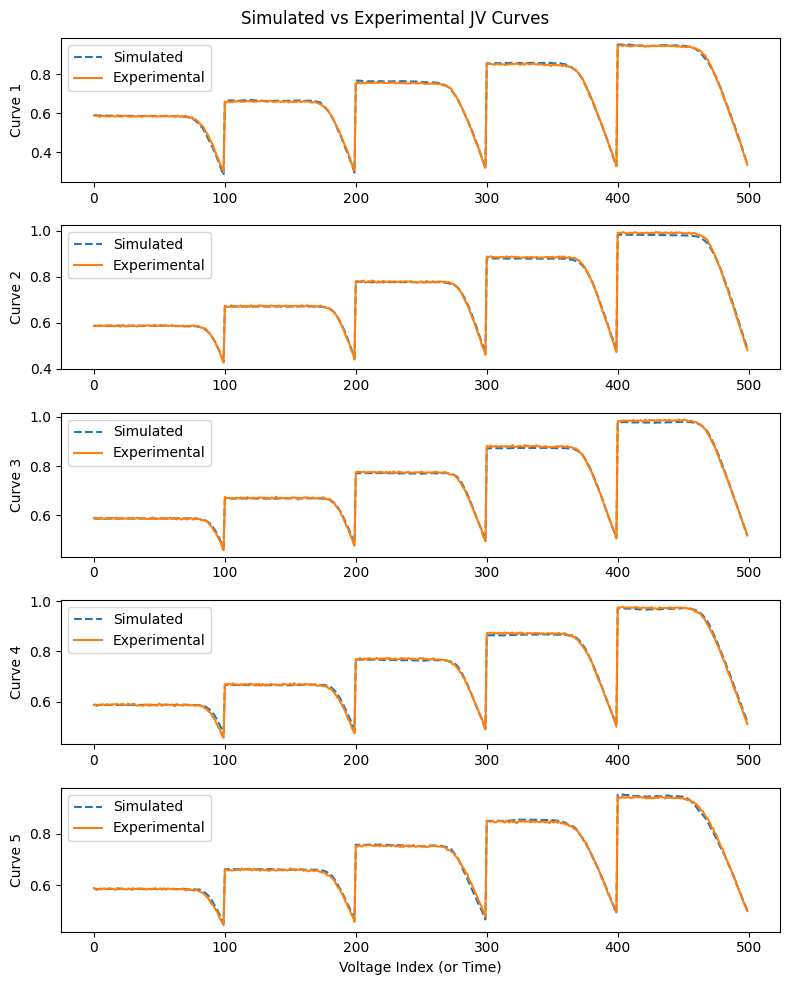

In [19]:
theta_last = optimized_params# Shape: (15,)
sim_JVs, _ = check_plot(theta_last, x_vals, 1)  # x is your experimental temperature grid

# ---- Plot simulated vs experimental JV curves ----

fig, ax = plt.subplots(5, 1, figsize=(8, 10))
for i in range(5):
    ax[i].plot(sim_JVs[i, :], '--', label='Simulated')
    ax[i].plot(JV_exp[i, :], label='Experimental')
    ax[i].set_ylabel(f'Curve {i+1}')
    ax[i].legend()
ax[-1].set_xlabel("Voltage Index (or Time)")
plt.suptitle("Simulated vs Experimental JV Curves")
plt.tight_layout()
plt.show()

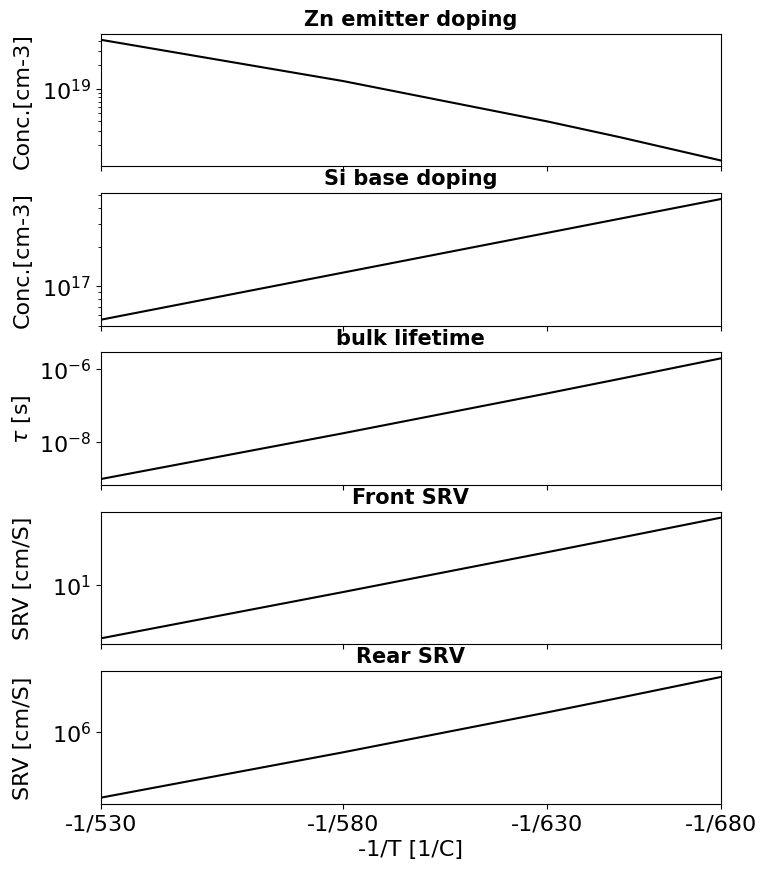

In [20]:

_, par_input = check_plot(optimized_params, x_vals, 0)
par_in = np.exp(par_input)

def plot_uncertain_2(x,y):
    plt.plot(x,y,color='black')

plt.rcParams["figure.figsize"] = [8, 10]
plt.rcParams.update({'font.size': 16})
 
fig = plt.figure()
y_label = ['Conc.[cm-3]','Conc.[cm-3]', r'$\tau$ [s]', 'SRV [cm/S]','SRV [cm/S]']
x_labels = ['-1/530' ,'-1/580','-1/630','-1/680']
title = ['Zn emitter doping' , 'Si base doping' ,'bulk lifetime','Front SRV', 'Rear SRV']

for i in range(5):
    plt.subplot(5,1,i+1)
    
    l1=plot_uncertain_2(x_vals,par_in[:,i]) 
    plt.yscale('log') 
    plt.ylabel(y_label[i])
    plt.xticks([-1000/530,-1000/580,-1000/630,-1000/680],[])
    plt.title(title[i],fontsize=15,fontweight='bold')
    plt.xlim(-1000/530,-1000/680)
    
  
plt.xticks([-1000/530,-1000/580,-1000/630,-1000/680], x_labels)

plt.xlabel(r'-1/T [1/C]') 

fig.align_labels()